Chat GPT's code

In [1]:
import numpy as np

def black_litterman(mu, sigma, P, Q, Omega):
    # Calculate the inverse of the covariance matrix
    omega_inverse = np.linalg.inv(Omega)
    
    # Calculate the Black-Litterman expected returns
    posterior_mu = mu + np.dot(np.dot(np.dot(sigma.T, np.linalg.inv(np.dot(np.dot(P.T, omega_inverse), P) + np.linalg.inv(sigma))), P.T), np.dot(omega_inverse, (Q - np.dot(P, mu))))
    
    # Calculate the Black-Litterman covariance matrix
    posterior_sigma = sigma + np.dot(np.dot(np.dot(sigma.T, np.linalg.inv(np.dot(np.dot(P.T, omega_inverse), P) + np.linalg.inv(sigma))), P.T), np.dot(omega_inverse, np.dot(P, sigma)))
    
    return posterior_mu, posterior_sigma

# Example inputs
mu = np.array([0.05, 0.07, 0.09])  # Market equilibrium expected returns
sigma = np.array([[0.1, 0.03, 0.05], [0.03, 0.12, 0.04], [0.05, 0.04, 0.15]])  # Market equilibrium covariance matrix
P = np.array([[1, 0, -1], [0, 1, -1]])  # Pick matrix
Q = np.array([0.02, 0.03])  # Views
Omega = np.diag([0.001, 0.002])  # Uncertainty matrix

# Calculate posterior expected returns and covariance matrix
posterior_mu, posterior_sigma = black_litterman(mu, sigma, P, Q, Omega)

print("Posterior Expected Returns:")
print(posterior_mu)
print("\nPosterior Covariance Matrix:")
print(posterior_sigma)


Posterior Expected Returns:
[0.04937435 0.06923014 0.08419381]

Posterior Covariance Matrix:
[[0.10167203 0.02696238 0.05199124]
 [0.02632529 0.1244731  0.03997147]
 [0.04810818 0.03674679 0.16095123]]


GitHub Repositories:
[yishantao/Black-Litterman](https://github.com/yishantao/Black-Litterman): An implementation of the Black-Litterman model in Python.
 
[overney/python](https://github.com/overney/python): Example of Black-Litterman model.

https://github.com/dmjz/BLP: Black-Litterman model portfolio optimizer.

[PythonForFinance Tutorial](https://www.pythonforfinance.net/2020/11/27/black-litterman-portfolio-allocation-model-in-python/): You can find a detailed tutorial on implementing the Black-Litterman model in Python on PythonForFinance.

In [270]:
#PythonForFinance approach

import numpy as np
import pandas as pd
from numpy.linalg import inv



# PRE-PROCESSING DATA
# NOTE: data is daily in a period of 3-month trailing 

price_df = pd.read_csv(r"C:\Users\jpkdu\Documents\GitHub\FinancialEngineering\My Projects\QuantConnect Projects\AdjPrice_data_QC_rev0.csv",parse_dates=['time'], index_col='time')

marketCap_df = pd.read_csv(r"C:\Users\jpkdu\Documents\GitHub\FinancialEngineering\My Projects\QuantConnect Projects\marketCap_data_QC_rev0.csv", index_col='stock')


returns_df = price_df.pct_change(1).dropna() # outputs returns df
log_returns_df = np.log(1 + returns_df) # ln(1+r) form

marketCap_weights_df = marketCap_df/(marketCap_df.sum())


#############################
# PythonForFinance code starts here

asset_returns_orig = log_returns_df
asset_weights = pd.DataFrame(data=marketCap_weights_df[marketCap_weights_df.columns[0]].values, index=marketCap_weights_df.index, columns=['weight']) # market cap weights
cols = log_returns_df.columns.values

asset_returns = asset_returns_orig[cols].dropna()
treasury_rate = pd.Series(data=[0 for x in log_returns_df.index.values], index=asset_returns.index)*(252/4) # annualized the 3-month data
asset_returns = asset_returns[cols].astype(np.float64).dropna()
asset_weights = asset_weights.loc[cols]


#########

excess_asset_returns = asset_returns.subtract(treasury_rate, axis=0) # R_excess = R - Rf ; vectorially
cov = excess_asset_returns.cov()*(252/4) # 3-month-ized the daily data
global_return = excess_asset_returns.mean().multiply(asset_weights['weight'].values).sum()*(252/4) # 3-month-ized the daily data # portfolio means of excess returns = E[R_global] - Rf = (E[R1] - Rf) * w1 + (E[R2] - Rf) * w2 + ... + (E[Rn] - Rf) * wn
market_var = np.matmul(asset_weights.values.reshape(len(asset_weights)).T,
                                       np.matmul(cov.values, asset_weights.values.reshape(len(asset_weights)))) # portfolio var of excess asset returns = asset_weights_T x Cov x asset_weights
#print(f'The global market mean return is {global_return:.4f} and the variance is {market_var:.6}')
risk_aversion = global_return / market_var # sharpe ratio: ( E[R_global] - Rf ) / portfolio var
#print(f'The risk aversion parameter is {risk_aversion:.2f}')


#######

# Let’s write our first function which will help us reverse engineer the weights of a portfolio to obtain the Implied Equilibrium Return Vector.

def implied_rets(risk_aversion, sigma, w):
    
    implied_rets = risk_aversion * sigma.dot(w).squeeze() # .squeeze() turns it into a series obj
    
    return implied_rets
implied_equilibrium_returns = implied_rets(risk_aversion, cov, asset_weights)  # annualized for 3-month trailing period
#implied_equilibrium_returns  # prior distribution


#######
# BETTER UPDATES: try to create a function that automatically creates P matrix given K x N and views

# % magnitude of equilibrium base i.e. excess return of asset = % * equilibrium base value
# 1 x K matrix, K = # of views
Q = np.array([0.0925, 0.005, 0.055]) 


# used to discriminate the assets that are indicated by the views
# equal weighting approach

P = np.asarray([[0, 0, 0, 0, 0, 1],      
    [0, 0, .5, -.5, .5, -.5],
    [0, 1, 0, 0, 0, 0]])

###########

def error_cov_matrix(sigma, tau, P):
    matrix = np.diag(np.diag(P.dot(tau * cov).dot(P.T))) # np.diag() - extracts the diagonal of the matrix
                                                         # np.diag(np.diag()) - outputs a matrix with the diagonal and zeroes everywhere
    return matrix

tau = 0.025 # best practice value
omega = error_cov_matrix(cov, tau, P)
#omega # covariance matrix of error random variables

###########

# calculate view-based vector

sigma_scaled = cov * tau
BL_return_vector = implied_equilibrium_returns + sigma_scaled.dot(P.T).dot(inv(P.dot(sigma_scaled).dot(P.T) + omega).dot(Q - P.dot(implied_equilibrium_returns)))

#BL_return_vector

############

# calculate the new Black Litterman based weights vector

inverse_cov = pd.DataFrame(inv(cov.values), index=cov.columns, columns=cov.index)
BL_weights_vector = inverse_cov.dot(BL_return_vector)
BL_weights_vector = BL_weights_vector/sum(BL_weights_vector)

BL_weights_vector


AMD      0.022857
AAPL     0.282861
WMT      0.013131
GOOGL    0.227614
NVDA     0.176941
DIS      0.276596
dtype: float64

In [271]:
# # compare the BL_return_vector with the original Implied Return Vector
returns_table = pd.concat([implied_equilibrium_returns, BL_return_vector], axis=1) * 100
returns_table.columns = ['Implied Returns', 'BL Return Vector']
returns_table['Difference'] = returns_table['BL Return Vector'] - returns_table['Implied Returns']
returns_table.style.format('{:,.2f}%')

,Implied Returns,BL Return Vector,Difference
AMD,13.18%,13.41%,0.24%
AAPL,4.86%,5.24%,0.38%
WMT,0.22%,-0.40%,-0.62%
GOOGL,7.09%,7.65%,0.57%
NVDA,17.83%,17.50%,-0.33%
DIS,1.69%,5.67%,3.98%


In [246]:
#  compare the new weights vector with the original Market Cap Weights below and the Mean-Variance optimised weights 
# (assuming we use the historic mean annual return as the return vector input)

# Calculate mean-variance optimised weights
MV_weights_vector = inverse_cov.dot(excess_asset_returns.mean())
MV_weights_vector = MV_weights_vector/sum(MV_weights_vector)
weights_table = pd.concat([BL_weights_vector, asset_weights, MV_weights_vector], axis=1) * 100
weights_table.columns = ['BL Weights', 'Market Cap Weights', 'Mean-Var Weights']
weights_table['BL/Mkt Cap Diff'] = weights_table['BL Weights'] - weights_table['Market Cap Weights']
weights_table.style.format('{:,.2f}%')

,BL Weights,Market Cap Weights,Mean-Var Weights,BL/Mkt Cap Diff
AMD,2.29%,3.04%,-53.75%,-0.76%
AAPL,28.29%,34.73%,-21.83%,-6.45%
WMT,1.31%,6.02%,87.77%,-4.71%
GOOGL,22.76%,26.01%,40.20%,-3.25%
NVDA,17.69%,27.81%,51.10%,-10.12%
DIS,27.66%,2.39%,-3.48%,25.27%


In [ ]:
# NEXT STEPS: X- double check where the annualization constant (252/4) was applied to
#             X- go back to old mean-var project and apply the same dataset
#             X- compare and analyze the results between two projects
#             - do 3rd party application using riskfolio or pyportfolioopt libraries

In [235]:

# MIGHT BE USED FOR AUTOMATING THE CREATION OF THE P matrix

import numpy as np

def update_matrix_value(matrix, row_index, col_index, new_value):
    """
    Updates the value in the given row and column of the input matrix.

    Args:
        matrix (np.ndarray): The existing matrix.
        row_index (int): Row index where the value should be updated.
        col_index (int): Column index where the value should be updated.
        new_value: The new value to set at the specified location.

    Returns:
        np.ndarray: The updated matrix.
    """
    updated_matrix = matrix.copy()  # Create a copy to avoid modifying the original matrix
    updated_matrix[row_index, col_index] = new_value
    return updated_matrix

# Example usage:
existing_matrix = np.zeros((3, 8))
new_row_index = 0
new_col_index = 1
new_value = 8

result_matrix = update_matrix_value(existing_matrix, new_row_index, new_col_index, new_value)
print(result_matrix)


[[0. 8. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


PythonForFinance Tutorial - Original Code

In [205]:
#PythonForFinance Tutorial

import numpy as np
import pandas as pd
from numpy.linalg import inv

asset_returns_orig = pd.read_csv('asset_returns.csv', index_col='Year', parse_dates=True)
asset_weights = pd.read_csv('asset_weights.csv', index_col='asset_class') # market cap weights
cols = ['Global Bonds (Unhedged)','Total US Bond Market','US Large Cap Growth',
            'US Large Cap Value','US Small Cap Growth','US Small Cap Value','Emerging Markets',
            'Intl Developed ex-US Market','Short Term Treasury']
asset_returns = asset_returns_orig[cols].dropna()
treasury_rate = asset_returns['Short Term Treasury']
asset_returns = asset_returns[cols[:-1]].astype(np.float64).dropna()
asset_weights = asset_weights.loc[cols[:-1]]

In [206]:
treasury_rate

Year
1995-01-01    0.12
1996-01-01    0.04
1997-01-01    0.07
1998-01-01    0.07
1999-01-01    0.02
2000-01-01    0.09
2001-01-01    0.08
2002-01-01    0.08
2003-01-01    0.02
2004-01-01    0.01
2005-01-01    0.02
2006-01-01    0.04
2007-01-01    0.08
2008-01-01    0.07
2009-01-01    0.01
2010-01-01    0.03
2011-01-01    0.02
2012-01-01    0.01
2013-01-01    0.00
2014-01-01    0.01
2015-01-01    0.00
2016-01-01    0.01
2017-01-01    0.00
2018-01-01    0.01
2019-01-01    0.04
2020-01-01    0.04
Name: Short Term Treasury, dtype: float64

In [5]:
asset_returns.tail()

,Global Bonds (Unhedged),Total US Bond Market,US Large Cap Growth,US Large Cap Value,US Small Cap Growth,US Small Cap Value,Emerging Markets,Intl Developed ex-US Market
Year,,,,,,,,
2016-01-01,0.04,0.03,0.06,0.17,0.11,0.25,0.12,0.02
2017-01-01,0.09,0.03,0.28,0.17,0.22,0.12,0.31,0.26
2018-01-01,-0.04,0.00,-0.03,-0.06,-0.06,-0.12,-0.15,-0.14
2019-01-01,0.07,0.09,0.37,0.26,0.33,0.23,0.20,0.22
2020-01-01,0.04,0.06,0.22,-0.13,0.09,-0.16,0.00,-0.09


In [6]:
asset_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26 entries, 1995-01-01 to 2020-01-01
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Global Bonds (Unhedged)      26 non-null     float64
 1   Total US Bond Market         26 non-null     float64
 2   US Large Cap Growth          26 non-null     float64
 3   US Large Cap Value           26 non-null     float64
 4   US Small Cap Growth          26 non-null     float64
 5   US Small Cap Value           26 non-null     float64
 6   Emerging Markets             26 non-null     float64
 7   Intl Developed ex-US Market  26 non-null     float64
dtypes: float64(8)
memory usage: 1.8 KB


In [7]:
asset_returns.describe()

,Global Bonds (Unhedged),Total US Bond Market,US Large Cap Growth,US Large Cap Value,US Small Cap Growth,US Small Cap Value,Emerging Markets,Intl Developed ex-US Market
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.00000,26.000000
mean,0.059615,0.054231,0.131538,0.102308,0.119615,0.114615,0.10000,0.063462
std,0.081706,0.041969,0.208398,0.175096,0.184228,0.184179,0.29685,0.195938
min,-0.060000,-0.020000,-0.380000,-0.360000,-0.400000,-0.320000,-0.53000,-0.410000
25%,-0.007500,0.032500,0.035000,0.002500,0.025000,-0.037500,-0.13000,-0.082500
50%,0.065000,0.055000,0.150000,0.145000,0.105000,0.165000,0.06500,0.065000
75%,0.107500,0.080000,0.287500,0.215000,0.215000,0.247500,0.28250,0.215000
max,0.230000,0.180000,0.420000,0.370000,0.430000,0.370000,0.76000,0.390000


In [11]:
asset_returns.mean()

Global Bonds (Unhedged)        0.059615
Total US Bond Market           0.054231
US Large Cap Growth            0.131538
US Large Cap Value             0.102308
US Small Cap Growth            0.119615
US Small Cap Value             0.114615
Emerging Markets               0.100000
Intl Developed ex-US Market    0.063462
dtype: float64

In [8]:
asset_weights

,weight
asset_class,
Global Bonds (Unhedged),0.224
Total US Bond Market,0.077
US Large Cap Growth,0.163
US Large Cap Value,0.162
US Small Cap Growth,0.022
US Small Cap Value,0.022
Emerging Markets,0.030
Intl Developed ex-US Market,0.299


In [9]:
asset_weights.sum()

weight    0.999
dtype: float64

In [10]:
excess_asset_returns = asset_returns.subtract(treasury_rate, axis=0) # R_excess = R - Rf ; vectorially
cov = excess_asset_returns.cov()
global_return = excess_asset_returns.mean().multiply(asset_weights['weight'].values).sum() # portfolio means of excess returns = E[R_global] - Rf = (E[R1] - Rf) * w1 + (E[R2] - Rf) * w2 + ... + (E[Rn] - Rf) * wn
market_var = np.matmul(asset_weights.values.reshape(len(asset_weights)).T,
                                       np.matmul(cov.values, asset_weights.values.reshape(len(asset_weights)))) # portfolio var of excess asset returns = asset_weights_T x Cov x asset_weights
print(f'The global market mean return is {global_return:.4f} and the variance is {market_var:.6}')
risk_aversion = global_return / market_var # sharpe ratio: ( E[R_global] - Rf ) / portfolio var
print(f'The risk aversion parameter is {risk_aversion:.2f}')

The global market mean return is 0.0446 and the variance is 0.0202548
The risk aversion parameter is 2.20


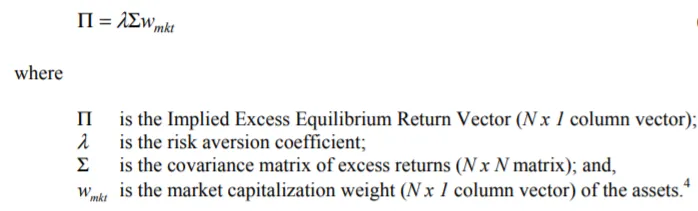

In [64]:
# Let’s write our first function which will help us reverse engineer the weights of a portfolio to obtain the Implied Equilibrium Return Vector.

def implied_rets(risk_aversion, sigma, w):
    
    implied_rets = risk_aversion * sigma.dot(w).squeeze() # .squeeze() turns it into a series obj
    
    return implied_rets
implied_equilibrium_returns = implied_rets(risk_aversion, cov, asset_weights)
implied_equilibrium_returns  # prior distribution

Global Bonds (Unhedged)        0.012871
Total US Bond Market           0.002439
US Large Cap Growth            0.060436
US Large Cap Value             0.051548
US Small Cap Growth            0.056798
US Small Cap Value             0.043902
Emerging Markets               0.076184
Intl Developed ex-US Market    0.063076
Name: weight, dtype: float64

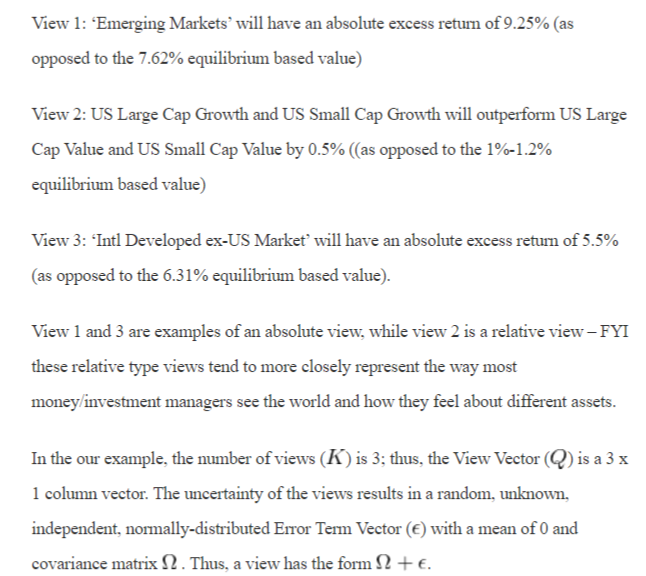

In [65]:
# % magnitude of equilibrium base i.e. excess return of asset = % * equilibrium base value
# 1 x K matrix, K = # of views
Q = np.array([0.0925, 0.005, 0.055]) 

# used to discriminate the assets that are indicated by the views
# equal weighting approach
P = [[0, 0, 0, 0, 0, 0, 1, 0],      
    [0, 0, .5, -.5, .5, -.5, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1]]

In [77]:
# x = size of large cap assets, y = size of small cap assets
# x = 5y , y = x/5
# total = 2x + 2y; since we have two large caps and two small caps are involved in View 2
# percentage of large cap assets: 2x / (2x + 2y) = 2x / (2x + 2*(x/5) ) = 2x / x*(12/5) = 2 * (5/12) = 0.8333 ~ 0.85
# percentage of small cap assets: 2y / (2x + 2y) = 2y / (2*(5y) +2y) = 2y / 12y = 2/12 = 0.1667 ~ 0.15

# market capitalization approach
P = np.asarray([[0, 0, 0, 0, 0, 0, 1, 0],
                [0, 0, .85, -.85, .15, -.15, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 1]])

# in both approaches, the rows must sum to zero
# each row of matrix P is a weight vector that is used to calculate a portfolio variance

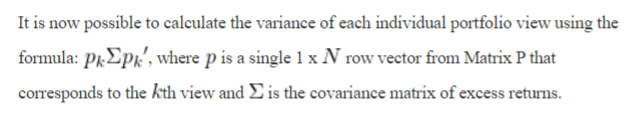

In [78]:
# portfolio variance = weights.T x Cov x weights
view1_var = np.matmul(P[0].reshape(len(P[0])),np.matmul(cov.values, P[0].reshape(len(P[0])).T))
view2_var = np.matmul(P[1].reshape(len(P[1])),np.matmul(cov.values, P[1].reshape(len(P[1])).T))
view3_var = np.matmul(P[2].reshape(len(P[2])),np.matmul(cov.values, P[2].reshape(len(P[2])).T))
print(f'The Variance of View 1 Portfolio is {view1_var}, and the standard deviation is {np.sqrt(view1_var):.3f}\n',\
      f'The Variance of View 2 Portfolio is {view2_var}, and the standard deviation is {np.sqrt(view2_var):.3f}\n',\
      f'The Variance of View 3 Portfolio is {view3_var}, and the standard deviation is {np.sqrt(view3_var):.3f}')


The Variance of View 1 Portfolio is 0.09655215384615386, and the standard deviation is 0.311
 The Variance of View 2 Portfolio is 0.014389680384615406, and the standard deviation is 0.120
 The Variance of View 3 Portfolio is 0.04505784615384616, and the standard deviation is 0.212


In [92]:
np.diag(np.diag(P.dot(tau * cov).dot(P.T)))

array([[0.0024138 , 0.        , 0.        ],
       [0.        , 0.00035974, 0.        ],
       [0.        , 0.        , 0.00112645]])

In [80]:
def error_cov_matrix(sigma, tau, P):
    matrix = np.diag(np.diag(P.dot(tau * cov).dot(P.T))) # np.diag() - extracts the diagonal of the matrix
                                                         # np.diag(np.diag()) - outputs a matrix with the diagonal and zeroes everywhere
    return matrix

tau = 0.025 # best practice value
omega = error_cov_matrix(cov, tau, P)
omega # covariance matrix of error random variables

array([[0.0024138 , 0.        , 0.        ],
       [0.        , 0.00035974, 0.        ],
       [0.        , 0.        , 0.00112645]])

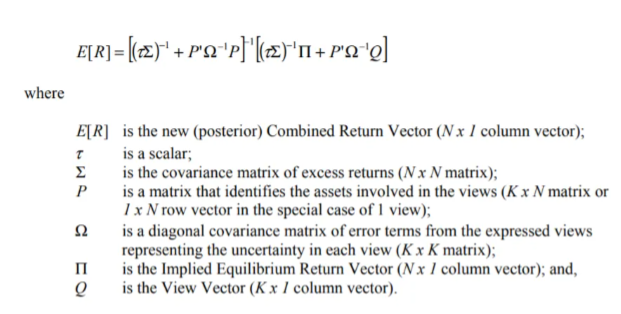

In [95]:
# calculate view-based vector

sigma_scaled = cov * tau
BL_return_vector = implied_equilibrium_returns + sigma_scaled.dot(P.T).dot(inv(P.dot(sigma_scaled).dot(P.T) + omega).dot(Q - P.dot(implied_equilibrium_returns)))

BL_return_vector

Global Bonds (Unhedged)        0.013157
Total US Bond Market           0.002431
US Large Cap Growth            0.057505
US Large Cap Value             0.050891
US Small Cap Growth            0.056636
US Small Cap Value             0.044942
Emerging Markets               0.079098
Intl Developed ex-US Market    0.062403
dtype: float64

In [96]:
# compare the BL_return_vector with the original Implied Return Vector
returns_table = pd.concat([implied_equilibrium_returns, BL_return_vector], axis=1) * 100
returns_table.columns = ['Implied Returns', 'BL Return Vector']
returns_table['Difference'] = returns_table['BL Return Vector'] - returns_table['Implied Returns']
returns_table.style.format('{:,.2f}%')

,Implied Returns,BL Return Vector,Difference
Global Bonds (Unhedged),1.29%,1.32%,0.03%
Total US Bond Market,0.24%,0.24%,-0.00%
US Large Cap Growth,6.04%,5.75%,-0.29%
US Large Cap Value,5.15%,5.09%,-0.07%
US Small Cap Growth,5.68%,5.66%,-0.02%
US Small Cap Value,4.39%,4.49%,0.10%
Emerging Markets,7.62%,7.91%,0.29%
Intl Developed ex-US Market,6.31%,6.24%,-0.07%


In [99]:
# calculate the new Black Litterman based weights vector

inverse_cov = pd.DataFrame(inv(cov.values), index=cov.columns, columns=cov.index)
BL_weights_vector = inverse_cov.dot(BL_return_vector)
BL_weights_vector = BL_weights_vector/sum(BL_weights_vector)

BL_weights_vector

Global Bonds (Unhedged)        0.226852
Total US Bond Market           0.077981
US Large Cap Growth            0.100581
US Large Cap Value             0.228558
US Small Cap Growth            0.010899
US Small Cap Value             0.033662
Emerging Markets               0.094175
Intl Developed ex-US Market    0.227293
dtype: float64

In [100]:
#  compare the new weights vector with the original Market Cap Weights below and the Mean-Variance optimised weights 
# (assuming we use the historic mean annual return as the return vector input)

# Calculate mean-variance optimised weights
MV_weights_vector = inverse_cov.dot(excess_asset_returns.mean())
MV_weights_vector = MV_weights_vector/sum(MV_weights_vector)
weights_table = pd.concat([BL_weights_vector, asset_weights, MV_weights_vector], axis=1) * 100
weights_table.columns = ['BL Weights', 'Market Cap Weights', 'Mean-Var Weights']
weights_table['BL/Mkt Cap Diff'] = weights_table['BL Weights'] - weights_table['Market Cap Weights']
weights_table.style.format('{:,.2f}%')

,BL Weights,Market Cap Weights,Mean-Var Weights,BL/Mkt Cap Diff
Global Bonds (Unhedged),22.69%,22.40%,-13.99%,0.29%
Total US Bond Market,7.80%,7.70%,107.26%,0.10%
US Large Cap Growth,10.06%,16.30%,17.54%,-6.24%
US Large Cap Value,22.86%,16.20%,-19.05%,6.66%
US Small Cap Growth,1.09%,2.20%,-1.82%,-1.11%
US Small Cap Value,3.37%,2.20%,16.43%,1.17%
Emerging Markets,9.42%,3.00%,6.39%,6.42%
Intl Developed ex-US Market,22.73%,29.90%,-12.75%,-7.17%


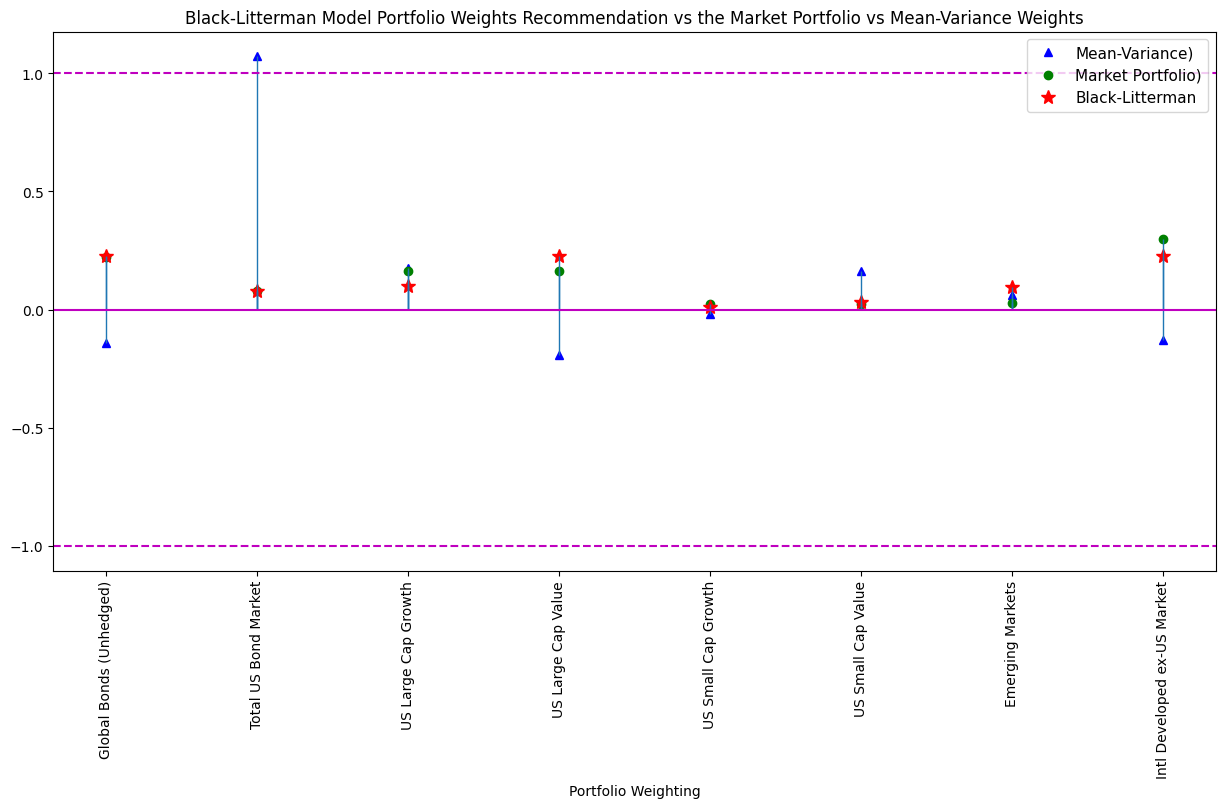

In [101]:
# Below is a visualisation of the various asset class weightings corresponding to:

import matplotlib.pyplot as plt
N = BL_weights_vector.shape[0]
fig, ax = plt.subplots(figsize=(15, 7))
ax.set_title('Black-Litterman Model Portfolio Weights Recommendation vs the Market Portfolio vs Mean-Variance Weights')
ax.plot(np.arange(N)+1, MV_weights_vector, '^', c='b', label='Mean-Variance)')
ax.plot(np.arange(N)+1, asset_weights, 'o', c='g', label='Market Portfolio)')
ax.plot(np.arange(N)+1, BL_weights_vector, '*', c='r',markersize=10, label='Black-Litterman')
ax.vlines(np.arange(N)+1, 0, BL_weights_vector, lw=1)
ax.vlines(np.arange(N)+1, 0, MV_weights_vector, lw=1)
ax.vlines(np.arange(N)+1, 0, asset_weights, lw=1)
ax.axhline(0, c='m')
ax.axhline(-1, c='m', ls='--')
ax.axhline(1, c='m', ls='--')
ax.set_xlabel('Assets')
ax.set_xlabel('Portfolio Weighting')
ax.xaxis.set_ticks(np.arange(1, N+1, 1))
ax.set_xticklabels(asset_weights.index.values)
plt.xticks(rotation=90, )
plt.legend(numpoints=1, fontsize=11)
plt.show()